In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Set global display options for cleaner output
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')


In [3]:
# Load the raw data file from the parent directory's data folder
df = pd.read_csv('../data/data.csv')

# Rename columns based on confirmed names from feature_engineering.py
df.rename(columns={'CustomerId': 'Customer_ID', 'TransactionStartTime': 'Transaction_Date'}, inplace=True)

# Convert the transaction time column to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

print(f"Total Transactions Loaded: {len(df)}")
print(f"Unique Customers for RFMS Calculation: {df['Customer_ID'].nunique()}")
df.head()

Total Transactions Loaded: 95662
Unique Customers for RFMS Calculation: 3742


,TransactionId,BatchId,AccountId,SubscriptionId,Customer_ID,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,Transaction_Date,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15 03:34:21+00:00,2,0


Top 5 Most Frequent Customers:
                 Transaction_Count
Customer_ID                       
CustomerId_7343               4091
CustomerId_3634               2085
CustomerId_647                1869
CustomerId_1096                784
CustomerId_4033                778


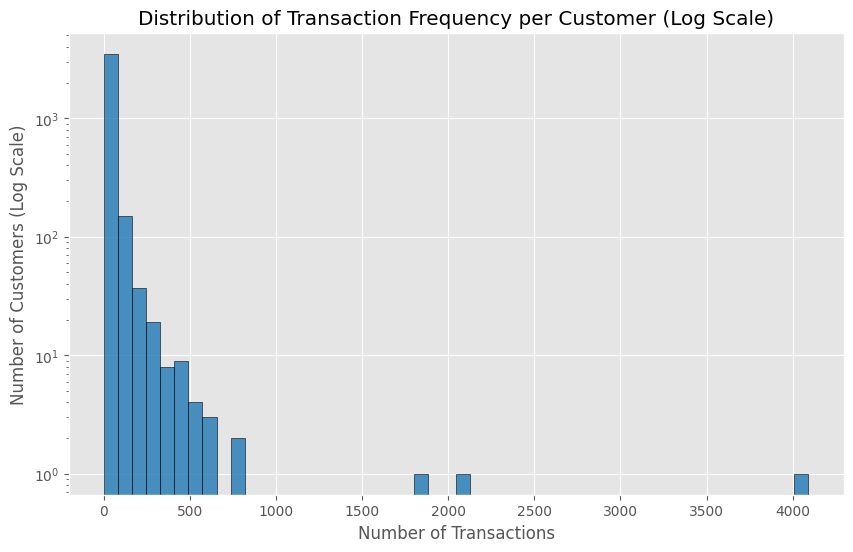

In [4]:
customer_counts = df.groupby('Customer_ID').size().sort_values(ascending=False)

print("Top 5 Most Frequent Customers:")
print(customer_counts.head().to_frame(name='Transaction_Count'))

plt.figure(figsize=(10, 6)) 
customer_counts.hist(bins=50, color='#1f77b4', alpha=0.8, edgecolor='black') 
plt.title('Distribution of Transaction Frequency per Customer (Log Scale)')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers (Log Scale)')
plt.yscale('log') # Log scale is essential to visualize the vast majority of low-frequency users
plt.show()

Transaction Amount Descriptive Statistics:
count      95662.000
mean        6717.846
std       123306.797
min     -1000000.000
25%          -50.000
50%         1000.000
75%         2800.000
max      9880000.000
Name: Amount, dtype: float64


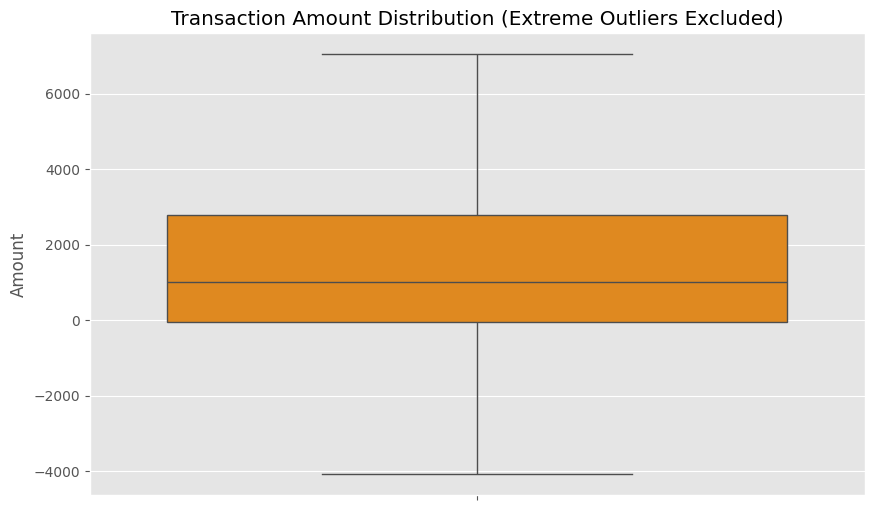

In [5]:
print("Transaction Amount Descriptive Statistics:")
print(df['Amount'].describe())

plt.figure(figsize=(10, 6)) 
sns.boxplot(y=df['Amount'], showfliers=False, color='darkorange')
plt.title('Transaction Amount Distribution (Extreme Outliers Excluded)')
plt.ylabel('Amount')
plt.show()

In [6]:
min_date = df['Transaction_Date'].min()
max_date = df['Transaction_Date'].max()
span = max_date - min_date

print(f"Data Collection Start Date: {min_date.date()}")
print(f"Data Collection End Date: {max_date.date()}")
print(f"Total Data Span: {span.days} days")
print(f"Recency Reference Date Used in Script: 2025-01-01")

Data Collection Start Date: 2018-11-15
Data Collection End Date: 2019-02-13
Total Data Span: 90 days
Recency Reference Date Used in Script: 2025-01-01
